### Importing Libraries
Import the required libraries for data analysis.

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader

import snntorch as snn
from snntorch import utils

In [2]:
class GraphDataset(Dataset):
    FILE_PATH = ''
    
    def __init__(self, user_id=None, label_list=None, num_samples=None, secs=None):
        self.user_id = user_id
        self.label_list = label_list
        self.num_samples = num_samples
        self.secs = secs
        
        self.data, self.labels = self.load_data(user_id, label_list, secs)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.Tensor(self.data[idx]), self.labels[idx]
    
    def load_data(self, user_id, label_list, secs):
        data = list()
        labels = list()
        
        for i in range(len(label_list)):
            for j in range(1, num_samples + 1):
                try:
                    adjMatrix = scipy.io.loadmat(
                        self.FILE_PATH + str(user_id) +
                        '_label' + str(label_list[i]) +
                        '_item' + str(j) + 'thr07_norm.mat')
                    
                except Exception as e:
                    print(f"Load fail: {e}")
                    continue
                    
                if secs == 1:
                    tmpAdjMatrix = adjMatrix['fullMatrix'][np.newaxis, :, :]
                else:
                    tmpAdjMatrix = list()
                    for k in range(self.secs):
                        tmpAdjMatrix.append(adjMatrix['fullMatrix'][:, :, k])
                                        
                data.append(np.array(tmpAdjMatrix))
                labels.append(label_list[i])
                                
        if not data or not labels:
            raise RuntimeError("No data or labels loaded.")
                    
        data = torch.tensor(np.stack(data), dtype=torch.float32)
                
        label_dict = {label: index for index, label in enumerate(self.label_list)}
        new_label_list = [label_dict[label] for label in labels]
        labels = torch.tensor(new_label_list, dtype=torch.long)
        
        return data, labels

### Loading Data
Load the full dataset.

In [3]:
user_id = 8
label_list = [769, 770, 771, 772]
num_samples = 72
secs = 1

In [4]:
full_dataset = GraphDataset(user_id=user_id, label_list=label_list, num_samples=num_samples, secs=secs)

Create the train and test set.

In [5]:
train_size = int(0.75 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [6]:
batch_size = 6

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Classification

In [7]:
# Dataloader arguments
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Temporal Dynamics
num_steps = 20
num_inputs = secs * 22 * 22

In [8]:
class Net(nn.Module):
    NUM_HIDDEN = 1000
    BETA = 0.95
    
    def __init__(self, num_steps, num_inputs, label_list):
        super().__init__()
        
        self.num_steps = num_steps
        self.num_inputs = num_inputs
        self.num_outputs = len(label_list)

        # Initialize layers
        self.fc1 = nn.Linear(self.num_inputs, self.NUM_HIDDEN)
        self.lif1 = snn.Leaky(beta = self.BETA)
        self.fc2 = nn.Linear(self.NUM_HIDDEN, self.num_outputs)
        self.lif2 = snn.Leaky(beta = self.BETA)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(self.num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net(num_steps, num_inputs, label_list).to(device)

In [9]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(data, targets, epoch, counter, iter_counter, loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [10]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [11]:
num_epochs = 10
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        
        data = data.to(device)
        targets = targets.to(device)
        
        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)
            
            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 28.37
Test Set Loss: 65.98
Train set accuracy for a single minibatch: 66.67%
Test set accuracy for a single minibatch: 16.67%


Epoch 1, Iteration 14
Train Set Loss: 19.13
Test Set Loss: 28.67
Train set accuracy for a single minibatch: 50.00%
Test set accuracy for a single minibatch: 33.33%


Epoch 2, Iteration 28
Train Set Loss: 17.04
Test Set Loss: 18.58
Train set accuracy for a single minibatch: 66.67%
Test set accuracy for a single minibatch: 50.00%


Epoch 4, Iteration 6
Train Set Loss: 23.28
Test Set Loss: 23.81
Train set accuracy for a single minibatch: 83.33%
Test set accuracy for a single minibatch: 33.33%


Epoch 5, Iteration 20
Train Set Loss: 11.34
Test Set Loss: 30.36
Train set accuracy for a single minibatch: 100.00%
Test set accuracy for a single minibatch: 33.33%


Epoch 6, Iteration 34
Train Set Loss: 14.94
Test Set Loss: 40.78
Train set accuracy for a single minibatch: 83.33%
Test set accuracy for a single minibatch: 16.67%


Epoch

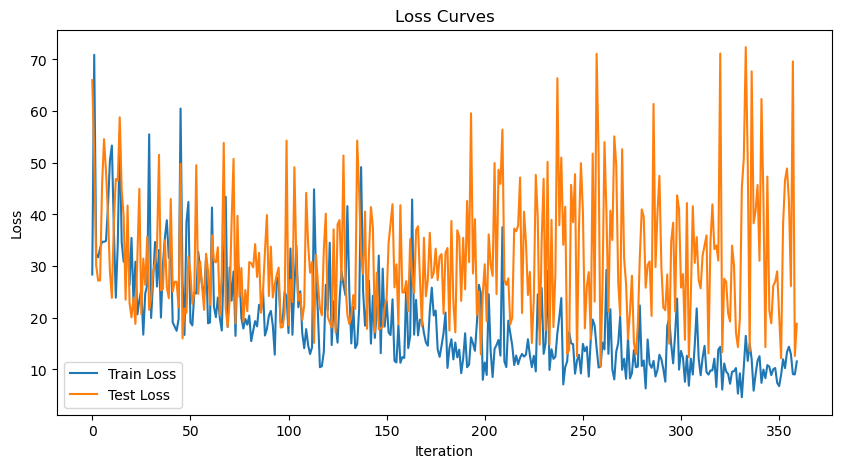

In [12]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [13]:
total = 0
correct = 0

with torch.no_grad():
    net.eval()
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
        
        # forward pass
        test_spk, _ = net(data.view(data.size(0), -1))
        
        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 36/72
Test Set Accuracy: 50.00%
